# Minority Report 

## London Crime Statistics 2008-2016

## Objective

Using the crime statistics for London from 2008-2016, investigate and analyse trends in the data.
Questions (a non-exhaustive list!):
- What are the most common crime categories?
- How do crimes vary by borough?
- How do crimes vary by year?
- Are there any seasonal variations to crime patterns?
- Can we use previous year's crime data to reliably predict future trends?
- Are there any additional features that we could use to help predict crime patterns?

## Exploratory Data Analysis

In [1]:
import pandas as pd
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# for speed, pickle the dataframe so that it can be quickly retrieved later on
crime_file = 'data/london_crime_by_lsoa.csv'
crime_pickle = crime_file + '.pickle'

if os.path.isfile(crime_pickle):
    crime = pd.read_pickle(crime_pickle)
else:
    crime = pd.read_csv(crime_file)
    crime.to_pickle(crime_pickle)

In [3]:
crime.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


In [4]:
# let's look at what I've got datawise
print("dtypes")
print(crime.dtypes)
print("=========")
print("shape")
print(crime.shape)

dtypes
lsoa_code         object
borough           object
major_category    object
minor_category    object
value              int64
year               int64
month              int64
dtype: object
shape
(13490604, 7)


In [5]:
# I'll want to do some time series analysis later on, so I'm going to create a timestamp from the year and month.
crime['day'] = 1
crime['date'] = pd.to_datetime(crime[['year','month','day']])
crime.drop('day', inplace=True, axis=1)

In [6]:
crime.head()

,lsoa_code,borough,major_category,minor_category,value,year,month,date
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11,2016-11-01
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11,2016-11-01
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5,2015-05-01
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3,2016-03-01
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6,2008-06-01


In [7]:
# look for any nulls in the data
crime.isnull().sum()

lsoa_code         0
borough           0
major_category    0
minor_category    0
value             0
year              0
month             0
date              0
dtype: int64

In [8]:
# check all the boroughs are present - should be 33 in total
print('Here is a list of boroughs:') 
print(crime['borough'].unique())
b_count = crime['borough'].nunique()
print(f'There are {b_count} distinct boroughs in this dataset!')

Here is a list of boroughs:
['Croydon' 'Greenwich' 'Bromley' 'Redbridge' 'Wandsworth' 'Ealing'
 'Hounslow' 'Newham' 'Sutton' 'Haringey' 'Lambeth' 'Richmond upon Thames'
 'Hillingdon' 'Havering' 'Barking and Dagenham' 'Kingston upon Thames'
 'Westminster' 'Hackney' 'Enfield' 'Harrow' 'Lewisham' 'Brent' 'Southwark'
 'Barnet' 'Waltham Forest' 'Camden' 'Bexley' 'Kensington and Chelsea'
 'Islington' 'Tower Hamlets' 'Hammersmith and Fulham' 'Merton'
 'City of London']
There are 33 distinct boroughs in this dataset!


In [9]:
#check that every minor category is unique to a given major category
#i.e. can I infer the major category from a given minor category.  This will be very useful at the modelling stage.
crime.groupby('minor_category')['major_category']\
  .apply(lambda x: x.nunique() == 1)\
  .all()

True

#### 1.  What are the most common crime categories in London?

In [10]:
#let's cut the data set so that Matplotlib doesn't have to work so hard!
crime_major = crime[crime['value']>0][['major_category','value']].groupby(by='major_category').sum().sort_values(by='value', ascending=False)
crime_major.head(3)

,value
major_category,
Theft and Handling,2661861
Violence Against the Person,1558081
Burglary,754293


In [11]:
# Green colour, retrieved from MS Paint and converted for standard RGB into decimal
color = (34,177,76)
color = tuple(ti/255 for ti in color)

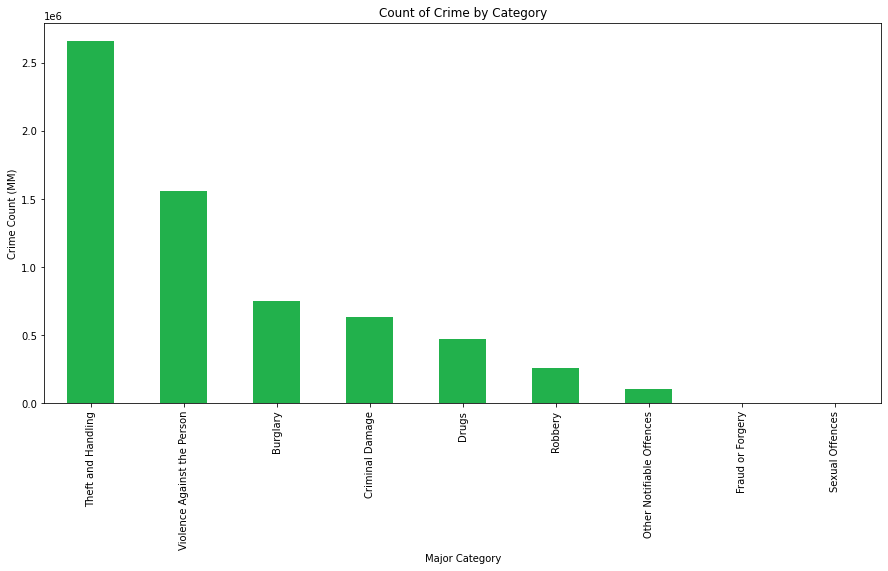

In [12]:
# generate a bar chart to show crime count by major category
fig, ax = plt.subplots(figsize=(15,7))
crime_major.plot.bar(figsize=(15,7), color=color, legend=False, ax=ax)
ax.set(xlabel='Major Category', ylabel='Crime Count (MM)', title='Count of Crime by Category')
plt.show()

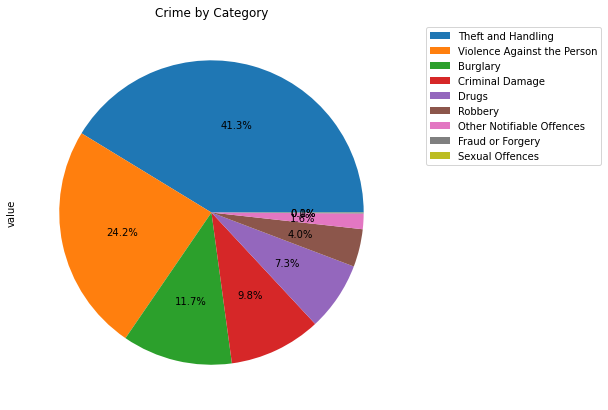

In [13]:
# generate a pie chart so we can see relative proportions
# yes yes, I know - Pie charts are usually verboten but this one is actually quite informative!
fig, ax = plt.subplots(figsize=(15,7))
crime_major.plot.pie(figsize=(15,7), ax=ax, y='value', labeldistance=None, autopct='%1.1f%%')
ax.set(title='Crime by Category')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

In [14]:
# what proportion of total crimes is taken up by the top 3 categories?
top3 = "{:.0%}".format((crime_major[crime_major.index.isin(['Theft and Handling','Violence Against the Person','Burglary'])].sum() / crime_major.sum()).value)
print(top3 + ' of the total number of crimes are accounted for by the top 3 categories.')

77% of the total number of crimes are accounted for by the top 3 categories.


#### A.  The top three crime categories in London account for 77% of the total number of crimes.  It will be interesting to see if this is consistently the case across each Borough.

#### 2.  What is the variation of crimes by Borough?

In [15]:
crime_major_borough = crime[crime['value']>0][['borough','major_category','value']].groupby(by=['major_category','borough']).sum().reset_index()
crime_major_borough = crime_major_borough.pivot(index='borough', columns='major_category', values='value').fillna(0).astype('int')
crime_major_borough.head(3)

major_category,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person
borough,,,,,,,,,
Barking and Dagenham,18103,18888,9188,205,2819,6105,49,50999,43091
Barnet,36981,21024,9796,175,2953,7374,38,87285,46565
Bexley,14973,17244,7346,106,1999,2338,22,40071,30037


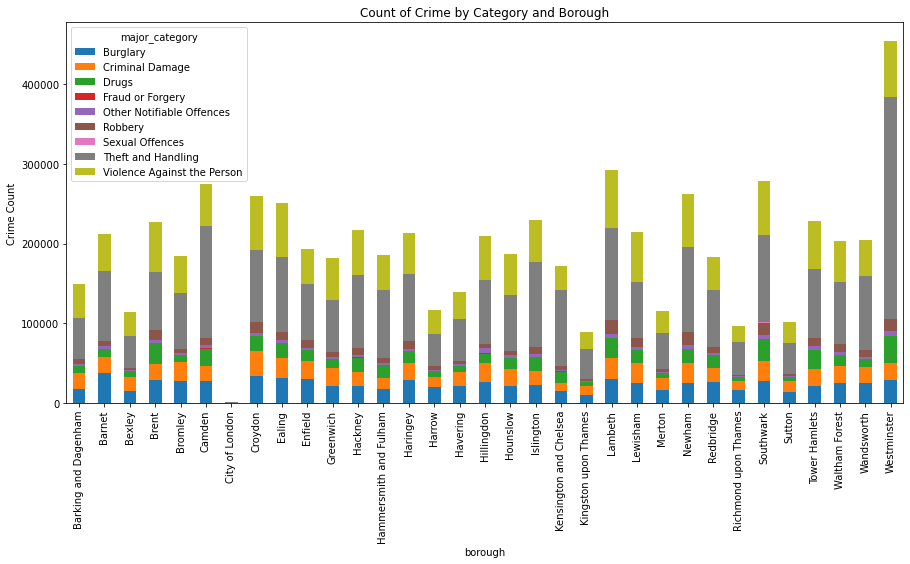

In [16]:
# generate a bar chart to show crime count by borough, and major category
fig, ax = plt.subplots()
crime_major_borough.plot(figsize=(15,7), legend=True, ax=ax, kind='bar', stacked=True)
ax.set(xlabel='borough', ylabel='Crime Count', title='Count of Crime by Category and Borough')
plt.show()

In [17]:
#it would be useful to know if the top3 crime types identified at the London-wide level holds true for every borough.
crime_major_borough['Top3_contribution'] = crime_major_borough[['Theft and Handling','Violence Against the Person','Burglary']].sum(axis=1)/crime_major_borough.sum(axis=1)

In [18]:
print(crime_major_borough['Top3_contribution'].idxmax(axis=1) + ' : ' + str(max(crime_major_borough['Top3_contribution'])))
print(crime_major_borough['Top3_contribution'].idxmin(axis=1) + ' : ' + str(min(crime_major_borough['Top3_contribution'])))

City of London : 0.8846153846153846
Brent : 0.7234597958259906


#### A.  Westminster has the highest crime rate by quite a significant amount, followed by Lambeth and Camden.  As per the stacked charts, we can observe that "Theft and Handling" is consistently the most common category of crime.  This is consistent with the "Top 3" categories observed in section 1, and at borough level, the top 3 crimes account for between 72% and 88% of all reported crimes.

#### 2b.  How might the borough level crime statistics look when placed on map of London?

In [19]:
import geopandas as gpd
from descartes import PolygonPatch
import matplotlib.pyplot as plt

In [20]:
crime_map = gpd.read_file('data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
crime_map.set_index('NAME', inplace=True)
crime_map = crime_map.join(crime[['borough','value']].groupby(['borough']).sum())
crime_map = crime_map.join(crime[['borough','value']][crime['major_category']=='Theft and Handling'].groupby(['borough']).sum().rename(columns={'value':'Theft and Handling'}))
crime_map = crime_map.join(crime[['borough','value']][crime['major_category']=='Violence Against the Person'].groupby(['borough']).sum().rename(columns={'value':'Violence Against the Person'}))
crime_map = crime_map.join(crime[['borough','value']][crime['major_category']=='Burglary'].groupby(['borough']).sum().rename(columns={'value':'Burglary'}))

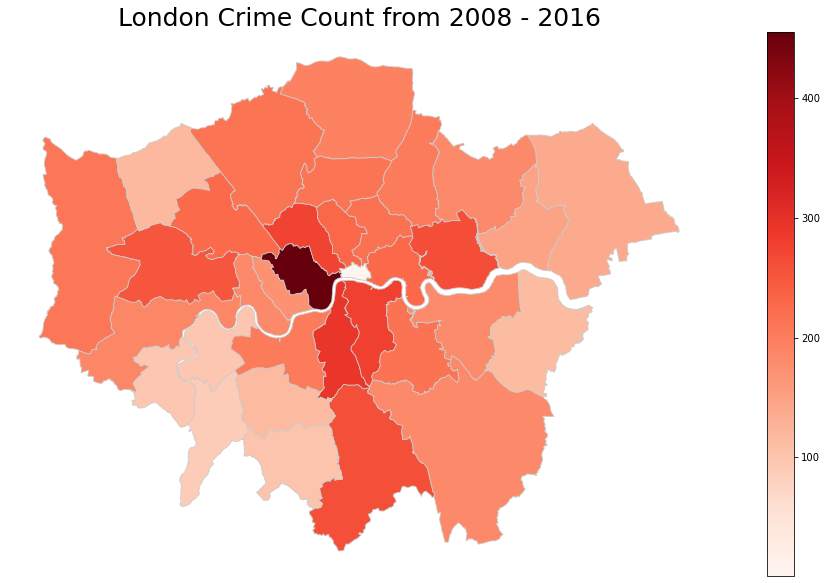

In [21]:
vmin = int(round(crime_map.value.max()/(10**3),0))
vmax = int(round(crime_map.value.min()/(10**3),0))
fig, ax = plt.subplots(1, figsize=(20,10))
crime_map.plot(column='value', cmap = 'Reds', linewidth=0.8, ax=ax, edgecolor='0.8')

ax.axis('off')

ax.set_title('London Crime Count from 2008 - 2016', fontdict={'fontsize':'25', 'fontweight':'3'})

sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

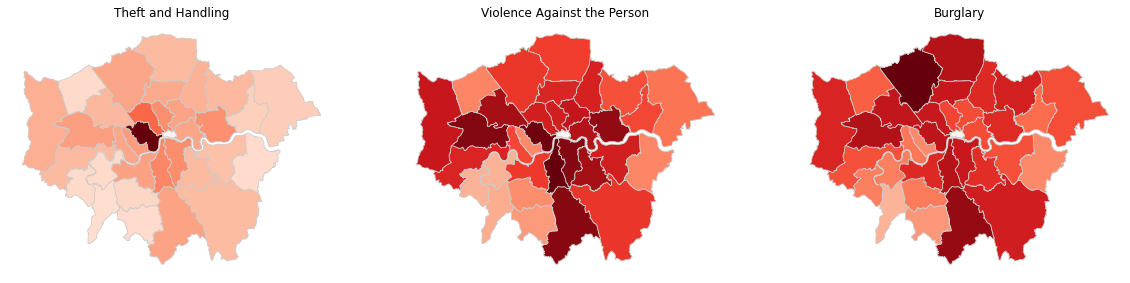

In [22]:
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, nrows=1, figsize=(20,10))
crime_map.plot(column='Theft and Handling', cmap = 'Reds', linewidth=0.8, ax=ax1, edgecolor='0.8')
crime_map.plot(column='Violence Against the Person', cmap = 'Reds', linewidth=0.8, ax=ax2, edgecolor='0.8')
crime_map.plot(column='Burglary', cmap = 'Reds', linewidth=0.8, ax=ax3, edgecolor='0.8')

ax1.set_title('Theft and Handling')
ax2.set_title('Violence Against the Person')
ax3.set_title('Burglary')

for ax in fig.axes:
    ax.axis('off')

#### A.  As we can see on the map above, Westminster stands out as the area with the greatest number of crimes.  There seems to be a general trend towards higher crime rates in the center of London with crime rates lower as we go further out.  Perhaps distance from Central London is a possible predictor.
#### Interestingly, we can see that for Theft and Handling, there is a high concentration in London, which quickly drops off as we go further out.

#### 3.  How does the crime rate vary by year?

In [23]:
crime_year = crime[crime['value']>0][['year','major_category','value']].groupby(by=['major_category','year']).sum().reset_index().sort_values(by='year')
crime_year = crime_year.pivot(index='year', columns='major_category', values='value').fillna(0).astype('int')
crime_year.head(3)

major_category,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person
year,,,,,,,,,
2008,88092,91872,68804,5325,10112,29627,1273,283692,159844
2009,90619,85565,60549,0,10644,29568,0,279492,160777
2010,86826,77897,58674,0,10768,32341,0,290924,157894


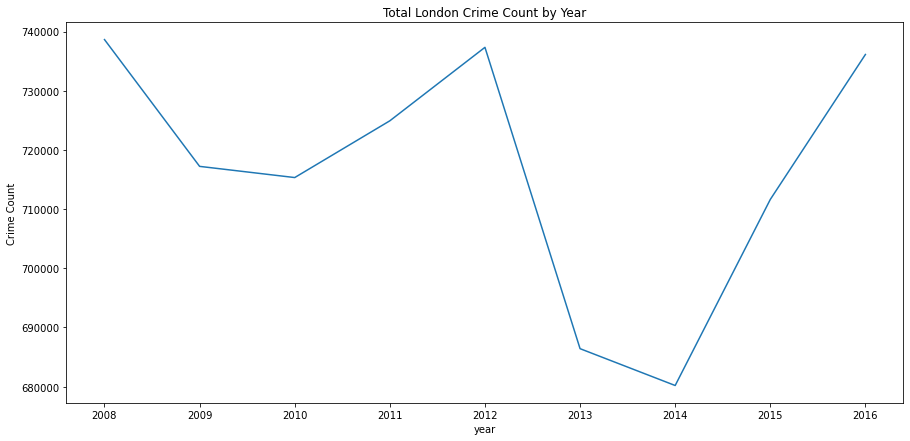

In [24]:
# generate a line chart to show london-wide crime trend by year
fig, ax = plt.subplots()
crime_year.sum(axis=1).plot(figsize=(15,7), legend=False, ax=ax, kind='line')
ax.set(xlabel='year', ylabel='Crime Count', title='Total London Crime Count by Year')
plt.show()

In [25]:
# That's a pretty jagged graph so perhaps we can smooth things out using some basis spline interpolation

from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

# 300 represents number of points to make between T.min and T.max
xold = crime_year.index
yold = crime_year.sum(axis=1)

xnew = np.linspace(xold.min(), xold.max(), 300) 

spl = make_interp_spline(xold, yold, k=3)  # type: BSpline
ynew = spl(xnew)

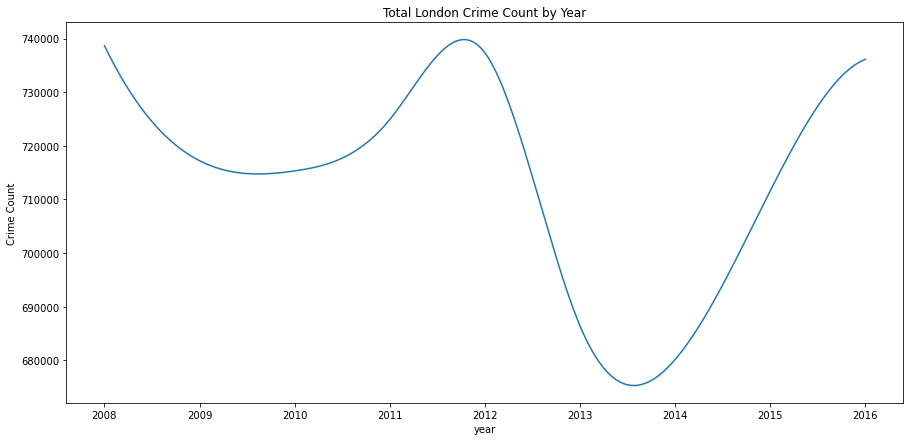

In [26]:
# regenerate the line chart to show london-wide crime trend by year with basis spline interpolation
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(xnew, ynew)

#, legend=False, ax=ax, kind='line')
ax.set(xlabel='year', ylabel='Crime Count', title='Total London Crime Count by Year')
plt.show()

#### A.  As we can see, averaged over the year, the crime rate seems to vary between 720-740k from 2008-2012.  From 2012 until mid 2013, the crime rate declines to around 680k before beginning the climb back ot 735k or so in 2016.  It may be interesting to investigate what may have caused this reduction and subsequent increase.

#### 3b.  What about if we break it down by category?

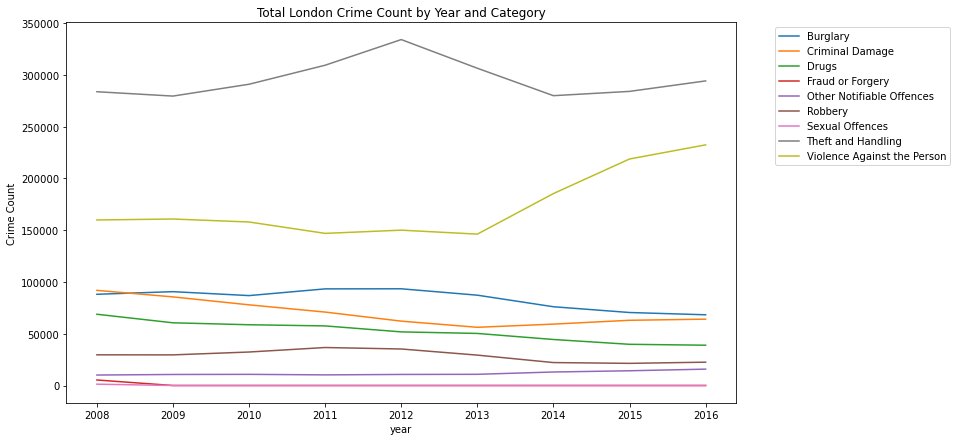

In [27]:
# Generate a similar line chart, with the London trade by year, including a breakdown by category
fig, ax = plt.subplots()
crime_year.plot(figsize=(12,7), legend=True, ax=ax, kind='line')
ax.set(xlabel='year', ylabel='Crime Count', title='Total London Crime Count by Year and Category')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

#### A.  Throughout most of the time period in question, the top 3 categories of crime remain the largest contributors, although Burglary is surpassed by Criminal Damage right at the beginning of the sample period.  Interestingly, we can also see from this graph that the reduction in crimes that took place from 2012 - mid 2013 appears to have been driven by the Theft and Handling category, whilst the subsequent increase appears to be driven by Violent Crime.

#### 4.  What does the Time Series look like?

In [28]:
crime_ts = crime[crime['value']>0][['date','value']].groupby(by=['date']).sum().sort_values(by='date')
crime_ts.head(3)

,value
date,
2008-01-01,65419
2008-02-01,62626
2008-03-01,61343


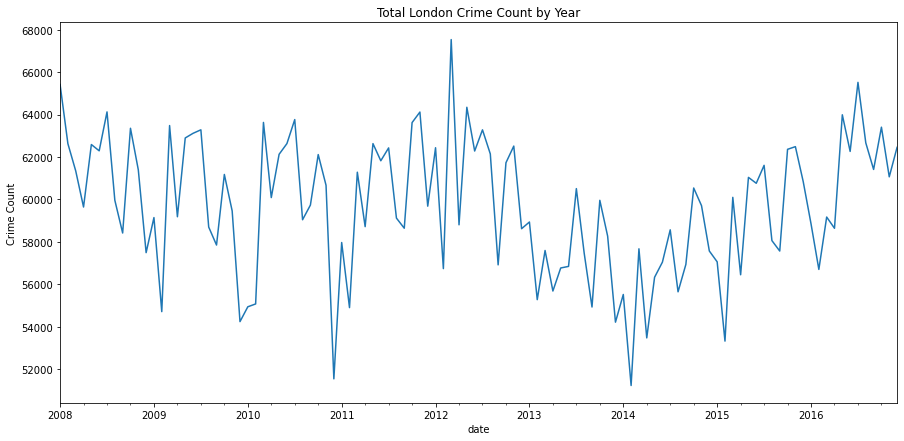

In [29]:
# Generate a line chartof the time series
fig, ax = plt.subplots()
crime_ts.plot(figsize=(15,7), legend=False, ax=ax, kind='line')
ax.set(xlabel='date', ylabel='Crime Count', title='Total London Crime Count by Year')
plt.show()

In [30]:
# let's do some splining again to make this look smoother
# b spline only works on a numeric value, so we need to switch datetime to numeric, do the spline, then switch it back again.

# 300 represents number of points to make between T.min and T.max
xold = pd.to_numeric(crime_ts.index)
yold = crime_ts.value

xnew = np.linspace(xold.min(), xold.max(), 5000) 

spl = make_interp_spline(xold, yold, k=3)  # type: BSpline
ynew = spl(xnew)
xnew = pd.to_datetime(xnew)

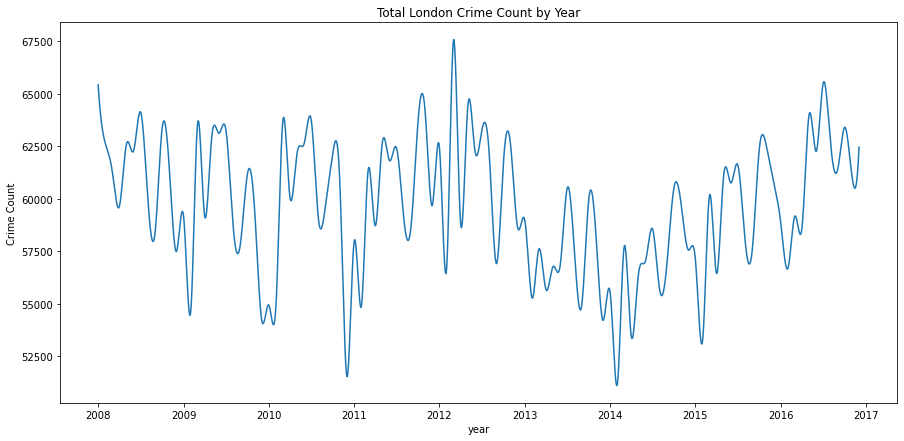

In [31]:
# regenerate the line chart to show london-wide crime trend by year with splining
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(xnew, ynew)

ax.set(xlabel='year', ylabel='Crime Count', title='Total London Crime Count by Year')
plt.show()

#### A.  Viewing the time series in this context doesn't give us too much information, although there does appear to be what looks like seasonality to the statistics.  We'll investigate this further in the next section.

#### 4b.  How does each year compare to the next?  are there any seaonal trends?

In [32]:
#let's plot a crude line graph of the month by month data, with each year as a different series.
crime_month = crime[crime['value']>0][['year','month','value']].groupby(by=['year','month']).sum().reset_index().sort_values(by='month')
crime_month = crime_month.pivot(index='month', columns='year', values='value').fillna(0).astype('int')
crime_month.head(3)

year,2008,2009,2010,2011,2012,2013,2014,2015,2016
month,,,,,,,,,
1,65419,59142,54934,57966,62436,58933,55515,57055,58847
2,62626,54706,55069,54895,56735,55271,51222,53316,56697
3,61343,63482,63629,61282,67537,57590,57669,60096,59167


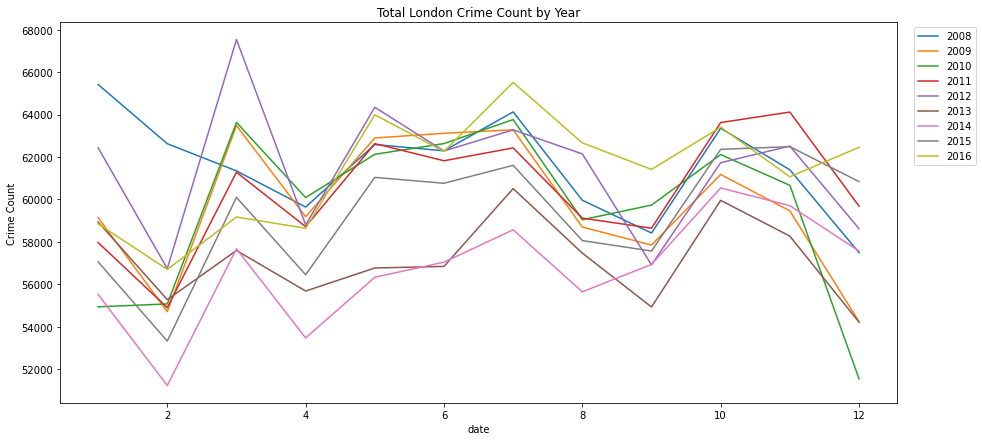

In [33]:
# Generate a line chartof the time series
fig, ax = plt.subplots()
crime_month.plot(figsize=(15,7), legend=True, ax=ax, kind='line')
ax.set(xlabel='date', ylabel='Crime Count', title='Total London Crime Count by Year')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

####  A.  Here, it is much easier to see a seasonality pattern emerging.  Granted, this is just a crude visual way of showing but it definitely warrants further investigation.

#### 4c.  Is there any auto-correlation here?  or Partial/ Seasonal auto-correlation?

In [34]:
# Load the autocorrelation function
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [35]:
# and the partial autocorrelation function
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

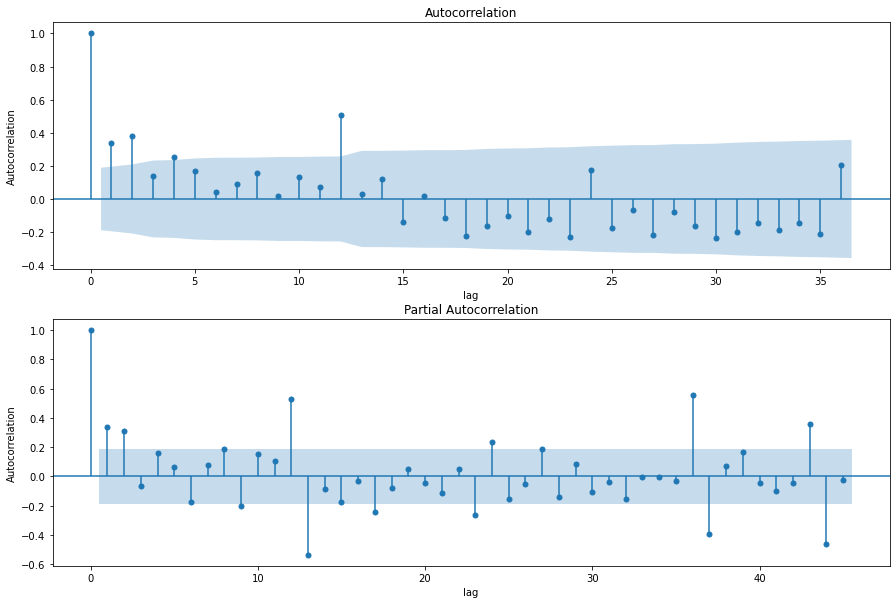

In [36]:
#plot both graphs
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

plot_acf(crime_ts.value.values, lags=36, ax=ax1)
ax1.set(xlabel='lag', ylabel='Autocorrelation')

plot_pacf(crime_ts.value.values, lags=45, ax=ax2)
ax2.set(xlabel='lag', ylabel='Autocorrelation')

plt.show()

#### A.  The Partial Autocorrelation graph is telling as it does seem to show a statistically significant seasonal correlation.  You can see the correlation points occuring at intervals of 12 months, which is in line with the lag in the data.

#### 4d.  Given the seasonality, can we decompose the time series to gain any further information?

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 432x288 with 0 Axes>

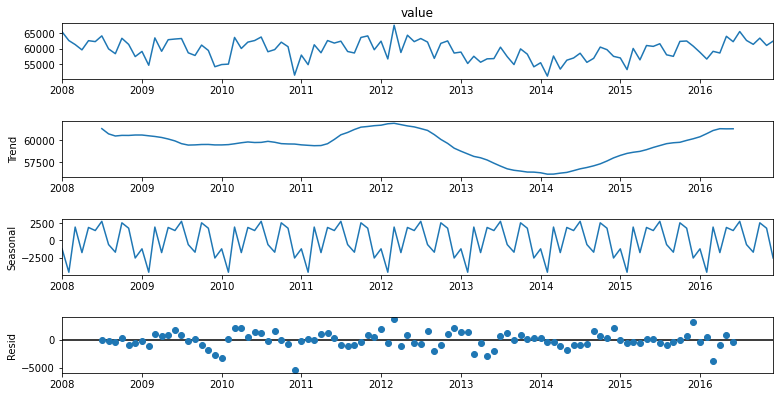

In [38]:
decomposition = seasonal_decompose(crime_ts.value)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(12, 6)

In [39]:
print('Seasonal variation accounts for a swing of ' + str(max(decomposition.seasonal)-min(decomposition.seasonal)))

Seasonal variation accounts for a swing of 7369.578125000002


#### So we can definitely see that the trendline is similarly shaped to the yearly plot above and that a the seasonal factor accounts for a change of around 7400 crimes.  This definitely points to the possibility of using a timeseries model to predict crime rates.

## Modelling

It seems likely that there will be a correlation between crime statistics and socioeconomic and demographic make up of the borough.  I will therefore enrich the dataset with some extra features and see how they are correlated.

In terms of making predictions, I am starting with the assumption that the minimum features that will need to be provided will be the date (since this is a time series), the borough and the crime category.

Let's begin by introducing some new features from datasources I obtained from the Office of National Statistics (ONS):
- Income
- Population 
- Job Seekers Allowance data
- Qualification Level

In [40]:
#let's create a version of the crime data set that we can add features to
#I don't need the data at lsoa level, so I'll group the data at borough level to reduce the data set
#I keep having to reload this, so I'm going to pickle it to speed things up.
crime_features_pickle = 'data/crime_features.pickle'

if os.path.isfile(crime_features_pickle):
    crime_features = pd.read_pickle(crime_features_pickle)
else:
    crime_features = crime.sort_values('date').groupby(by=['date','borough','major_category','minor_category']).sum()['value'].reset_index()
    crime_features.to_pickle(crime_features_pickle)

In [41]:
crime_features

,date,borough,major_category,minor_category,value
0,2008-01-01,Barking and Dagenham,Burglary,Burglary in Other Buildings,55
1,2008-01-01,Barking and Dagenham,Burglary,Burglary in a Dwelling,79
2,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,78
3,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,142
4,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,18
...,...,...,...,...,...
112963,2016-12-01,Westminster,Violence Against the Person,Harassment,288
112964,2016-12-01,Westminster,Violence Against the Person,Murder,1
112965,2016-12-01,Westminster,Violence Against the Person,Offensive Weapon,19
112966,2016-12-01,Westminster,Violence Against the Person,Other violence,29


In [42]:
#let's create a list to house the new features - could come in handy later!
new_features = []

#### Income data

In [43]:
#income data is by year, so we need to create that column to join on
crime_features['year'] = crime_features['date'].dt.year

In [44]:
# get the income data.  It is already normalised as weekly values are median earnings
ons_income = pd.read_excel('data/earnings-residence-borough.xlsx', sheet_name='Total, weekly')
ons_income = ons_income.loc[ons_income.Code.str.startswith("00").fillna(False), ons_income.columns.str.startswith("U")!=True]
ons_income = ons_income.drop('Code', axis=1).set_index('Area').apply(pd.to_numeric, errors='coerce')

In [45]:
#stack the data so it can be joined to the crime dataset.
ons_income = ons_income.stack().reset_index().rename(columns={'level_1':'year',0:'weekly_earnings','Area':'borough'})


In [46]:
# merge it with the crime_features dataframe
crime_features = crime_features.merge(right=ons_income, how='left', on=['borough','year'])
new_features.append('weekly_earnings')
crime_features.head()

,date,borough,major_category,minor_category,value,year,weekly_earnings
0,2008-01-01,Barking and Dagenham,Burglary,Burglary in Other Buildings,55,2008,449.9
1,2008-01-01,Barking and Dagenham,Burglary,Burglary in a Dwelling,79,2008,449.9
2,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,78,2008,449.9
3,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,142,2008,449.9
4,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,18,2008,449.9


#### Population data

In [47]:
#get the population data and clean it up
ons_population = pd.read_excel('data/london_borough_pop_by_year.xlsx', sheet_name='Data', header=6)
ons_population.rename(columns={'local authority: district / unitary (as of April 2019)':'borough'}, inplace=True)
ons_population.set_index('borough', inplace=True)

In [48]:
#stack the data so it can be joined to the crime dataset
ons_population = ons_population[ons_population.index!='Column Total'].stack().reset_index().rename(columns={'level_1':'year',0:'population'})

In [49]:
crime_features = crime_features.merge(right=ons_population, how='inner', on=['borough','year'])
new_features.append('population')
crime_features.head()

,date,borough,major_category,minor_category,value,year,weekly_earnings,population
0,2008-01-01,Barking and Dagenham,Burglary,Burglary in Other Buildings,55,2008,449.9,172500
1,2008-01-01,Barking and Dagenham,Burglary,Burglary in a Dwelling,79,2008,449.9,172500
2,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,78,2008,449.9,172500
3,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,142,2008,449.9,172500
4,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,18,2008,449.9,172500


#### Job Seekers Allowance data

In [50]:
#JSA data is by quarter, so we need to create that column in the crime data to join on
crime_features['quarter'] = crime_features['date'].dt.to_period('Q')

In [51]:
#get the jsa data and clean it up
ons_jsa = pd.read_excel('data/job-seekers-allowance-borough.xls', sheet_name='Numbers')
ons_jsa.dropna(inplace=True)
ons_jsa = ons_jsa[ons_jsa.Code.str.startswith('E09')].set_index('Area').drop(columns='Code')

In [52]:
# stack the data so it can be easily joined to the main "crime" table.  We'll need to create the "quarter" column.
ons_jsa = ons_jsa.stack().reset_index().rename(columns={'level_1':'date',0:'jsa_count'})
ons_jsa['quarter'] = ons_jsa.date.dt.to_period('Q')
ons_jsa.drop('date', axis=1, inplace=True)
ons_jsa.rename(columns={'Area':'borough'}, inplace=True)
ons_jsa['jsa_count'] = ons_jsa['jsa_count'].astype('int64')

In [53]:
crime_features = crime_features.merge(right=ons_jsa, how='left', on=['borough','quarter'])
crime_features.head()

,date,borough,major_category,minor_category,value,year,weekly_earnings,population,quarter,jsa_count
0,2008-01-01,Barking and Dagenham,Burglary,Burglary in Other Buildings,55,2008,449.9,172500,2008Q1,3640
1,2008-01-01,Barking and Dagenham,Burglary,Burglary in a Dwelling,79,2008,449.9,172500,2008Q1,3640
2,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,78,2008,449.9,172500,2008Q1,3640
3,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,142,2008,449.9,172500,2008Q1,3640
4,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,18,2008,449.9,172500,2008Q1,3640


Unlike qualifications or earnings, which are normalised (either percentage of population, or per head), jsa_count is an outright number.  therefore we should normalise this value as well to avoid the risk of multi-collinearity.  I'll use population to normalise this feature.

In [54]:
crime_features['jsa'] = crime_features['jsa_count'] * 100 / crime_features['population']
crime_features.drop('jsa_count', inplace=True, axis=1)
new_features.append('jsa')
crime_features.head()

,date,borough,major_category,minor_category,value,year,weekly_earnings,population,quarter,jsa
0,2008-01-01,Barking and Dagenham,Burglary,Burglary in Other Buildings,55,2008,449.9,172500,2008Q1,2.110145
1,2008-01-01,Barking and Dagenham,Burglary,Burglary in a Dwelling,79,2008,449.9,172500,2008Q1,2.110145
2,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,78,2008,449.9,172500,2008Q1,2.110145
3,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,142,2008,449.9,172500,2008Q1,2.110145
4,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,18,2008,449.9,172500,2008Q1,2.110145


#### Professional qualifications

In [55]:
# get the data and clean it up
ons_qual = pd.read_csv('data/Qualifications-of-working-age-NVQ.csv')
ons_qual = ons_qual.rename(columns={'Qualifications of working age population (16-64)':'qualification','Year':'year','Area':'borough'})
ons_qual.drop(['Code','number','denominator','confidence'], axis=1, inplace=True)
ons_qual['percent'] = ons_qual['percent'].apply(pd.to_numeric, errors='coerce').fillna(0)

In [56]:
# check qualification labels - we cna see some inconsistencies in naming
ons_qual['qualification'].drop_duplicates().to_list()

['NVQ4+',
 'NVQ3 only',
 'Trade Apprenticeships',
 'NVQ2 only',
 'NVQ1 only',
 'with other qualifications',
 'with no qualifications',
 'NVQ2 only ',
 'other qualifications',
 'no qualifications',
 ' NVQ4+ ']

In [57]:
# clean up the qualification names in the dataset
di = {' NVQ4+ ':'NVQ4+','NVQ2 only ':'NVQ2 only','with other qualifications':'other qualifications','with no qualifications':'no qualifications'}
ons_qual['qualification'] = ons_qual['qualification'].map(di).fillna(ons_qual['qualification'])
new_features.extend(ons_qual['qualification'].drop_duplicates().to_list())

In [58]:
#unstack the data so its in the right format for applying to the crime dataset
ons_qual = ons_qual.set_index(['borough','year','qualification']).unstack('qualification').reset_index()
ons_qual.columns = ons_qual[['borough','year']].columns.droplevel(1).append(ons_qual['percent'].columns)

In [59]:
crime_features = crime_features.merge(right=ons_qual, how='left', on=['borough','year'])
crime_features.head()

,date,borough,major_category,minor_category,value,year,weekly_earnings,population,quarter,jsa,NVQ1 only,NVQ2 only,NVQ3 only,NVQ4+,Trade Apprenticeships,no qualifications,other qualifications
0,2008-01-01,Barking and Dagenham,Burglary,Burglary in Other Buildings,55,2008,449.9,172500,2008Q1,2.110145,14.0,13.3,10.6,20.5,2.3,23.9,15.5
1,2008-01-01,Barking and Dagenham,Burglary,Burglary in a Dwelling,79,2008,449.9,172500,2008Q1,2.110145,14.0,13.3,10.6,20.5,2.3,23.9,15.5
2,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,78,2008,449.9,172500,2008Q1,2.110145,14.0,13.3,10.6,20.5,2.3,23.9,15.5
3,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,142,2008,449.9,172500,2008Q1,2.110145,14.0,13.3,10.6,20.5,2.3,23.9,15.5
4,2008-01-01,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,18,2008,449.9,172500,2008Q1,2.110145,14.0,13.3,10.6,20.5,2.3,23.9,15.5


In [60]:
#check if any features have added nulls to our data... uh oh, there are some in weekly_earnings!
crime_features.isnull().sum()

date                        0
borough                     0
major_category              0
minor_category              0
value                       0
year                        0
weekly_earnings          2112
population                  0
quarter                     0
jsa                         0
NVQ1 only                   0
NVQ2 only                   0
NVQ3 only                   0
NVQ4+                       0
Trade Apprenticeships       0
no qualifications           0
other qualifications        0
dtype: int64

In [61]:
crime_features[crime_features['weekly_earnings'].isna()].drop_duplicates(['borough','year'])[['borough','year']]

,borough,year
2304,City of London,2008
27408,City of London,2010
39960,City of London,2011
52512,City of London,2012
65064,City of London,2013
77616,City of London,2014
90168,City of London,2015
102720,City of London,2016


In [62]:
#as per the above, all of the missing figures are for City of London which has almost no crime data anyway.
#it should be safe enough to just populate zeros without impacting any modelling too much!
crime_features['weekly_earnings'].fillna(0, inplace=True)

### Now that we have our new dataset, let's see if we can spot any correlation between these new features and the count of crimes

In [63]:
#let's load the matplotlib and seaborn libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [64]:
#create feature column variables - I won't add all of the qualification features as it'll be difficult to visualise
feature_cols = ['weekly_earnings','jsa','population','NVQ4+','no qualifications']

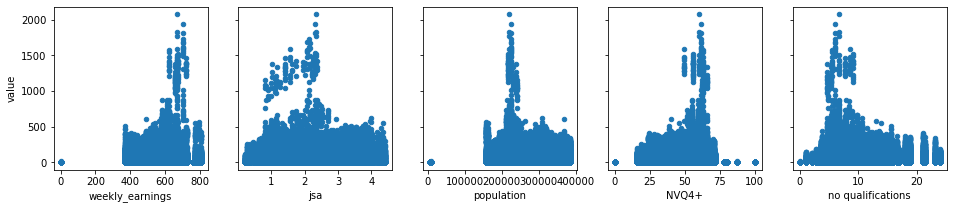

In [65]:
# Let's plot each feature vs. crime count
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    crime_features.plot(kind='scatter', x=feature, y='value', ax=axs[index], figsize=(16, 3))

Could different population sizes by clouding the picture?  what if I normlise the crime count by population and rerun this?

In [66]:
#calculate crime count as a percentage of population and add it to the dataframe
crime_features['value_normalised'] = crime_features['value'] * 100 / crime_features['population']

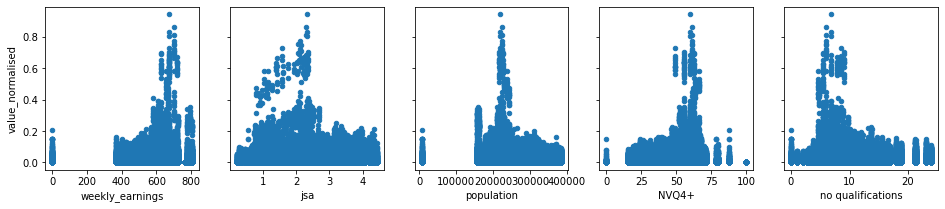

In [67]:
# Now' let's replot using the normalised count
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    crime_features.plot(kind='scatter', x=feature, y='value_normalised', ax=axs[index], figsize=(16, 3))

Normalising by borough population doesn't appear to have improved things much.  There appear to be fairly weak correlations between these features and the total crime count.  
Could breaking things down further by crime category improve things further?

Let's look at the top 3 crime categories:
- Theft and Handling
- Violence Against the Person
- Burglary

In [68]:
crime_top3 = ['Theft and Handling','Violence Against the Person','Burglary']

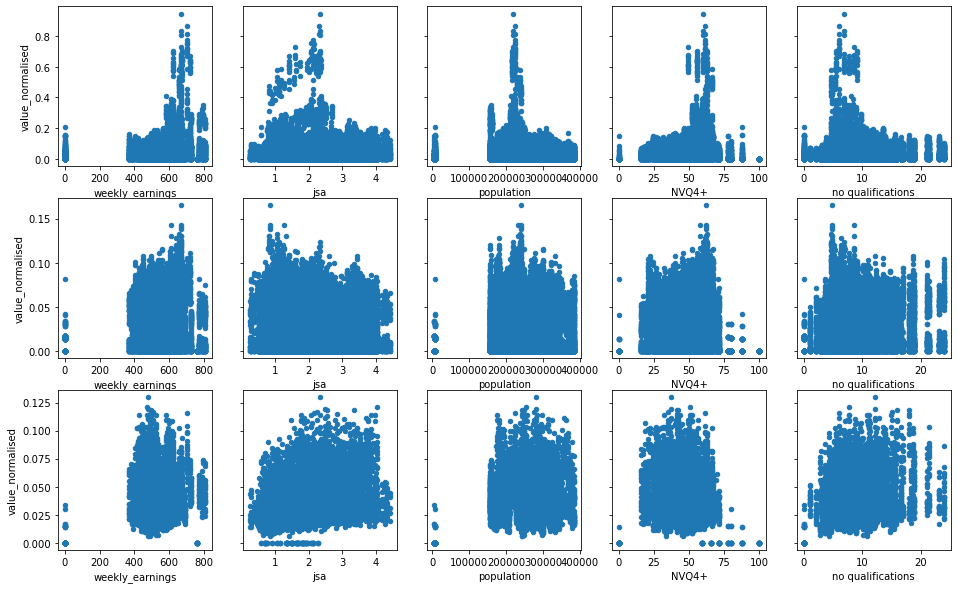

In [69]:
# Now' let's replot using the normalised count
fig, axs = plt.subplots(len(crime_top3), len(feature_cols), sharey='row')
for indexrow, cat in enumerate(crime_top3):
    for indexcol, feature in enumerate(feature_cols):
        crime_features[crime_features['major_category']==cat].plot(kind='scatter', x=feature, y='value_normalised', ax=axs[indexrow,indexcol], figsize=(16, 10))

Here we can see some indication of correlation between features, once we take into account the crime category.  I suspect if we add borough in as well, this might be even more obvious.

### Building the Model

Now that I've selected some features,  its time to start building the model.  

In addition to the above features, there is also the time-series data itself.  
Based on some of the analysis performed in the EDA stage, I'm confident that factors such as seasonality will come into play.

With that in mind, I am leaning towards an ARIMA model, but I don't want to be constrained by only working with time-series data.  Therefore I propose to start off with a basic linear regression model which will allow me to work with various features, and build a separate ARIMA model whose output will become one of the features of the linear regression.

#### 1st Iteration

In [70]:
# I'll pick up where I left off at the end of the features analysis, and take a copy of that dataset to work on.
# Because I'll be doing a train-test split, I need to ensure the data is in date order
crime_model = crime_features.sort_values(by='date').reset_index().drop(columns='index')
#crime_model = crime_model.groupby(by=['date','borough','major_category']).sum().reset_index().rename(columns={'major_category':'minor_category'})
crime_model.head(3)

,date,borough,major_category,minor_category,value,year,weekly_earnings,population,quarter,jsa,NVQ1 only,NVQ2 only,NVQ3 only,NVQ4+,Trade Apprenticeships,no qualifications,other qualifications,value_normalised
0,2008-01-01,Barking and Dagenham,Burglary,Burglary in Other Buildings,55,2008,449.9,172500,2008Q1,2.110145,14.0,13.3,10.6,20.5,2.3,23.9,15.5,0.031884
1,2008-01-01,Merton,Sexual Offences,Rape,4,2008,526.0,195900,2008Q1,1.061766,11.9,12.5,8.8,37.8,3.3,7.9,17.9,0.002042
2,2008-01-01,Merton,Sexual Offences,Other Sexual,7,2008,526.0,195900,2008Q1,1.061766,11.9,12.5,8.8,37.8,3.3,7.9,17.9,0.003573


In [71]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import numpy as np

In [72]:
# To begin with, I'll build a linear regression model taking Timestamp, Borough and Minor Category as inputs.
# I'll create functions for some elements of the model, so I can reuse the code as I tune it.

In [73]:
# Function which accepts a list of features, returns testing RMSE/Null RMSE and writes the prediction to a global variable.
def run_lr(feature_cols):
    global y_pred_df
    
    X = crime_model[feature_cols]
    y = crime_model.value
    
    #because this is a timeseries, we need to ensure the split happens in chronological order
    split = int(len(crime_model)*0.75)
    X_train = X[:split]
    X_test = X[split:]
    y_train = y[:split]
    y_test = y[split:]
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    y_pred_df = pd.DataFrame(y_pred).set_index(y_test.index).rename(columns={0:'value_pred'})
    
    y_null = np.zeros_like(y_test, dtype=float)
    y_null.fill(y_test.mean())
    
    return 'RMSE: ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),\
           'Null RMSE: ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_null)))
#    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [74]:
# Function which plots the regression just completed for a given list of category/borough combinations
def plot_regression(borough, cat):
    
    plot_data = crime_model.join(y_pred_df, how='left')
    split = int(len(plot_data)*0.75)
    plot_train = plot_data[:split].groupby(['major_category','borough','date']).sum().reset_index()
    plot_test = plot_data[split:].groupby(['major_category','borough','date']).sum().reset_index()
    
    fig, axs = plt.subplots(len(borough), len(cat), squeeze=False, figsize=(5*len(cat),3*len(borough)))
    for indexrow, b in enumerate(borough):
        for indexcol, c in enumerate(cat):
            plot_train[(plot_train['major_category']==c) & (plot_train['borough']==b)][['date','value']].set_index('date').plot(ax=axs[indexrow, indexcol])
            plot_test[(plot_test['major_category']==c) & (plot_test['borough']==b)][['date','value']].set_index('date').plot(ax=axs[indexrow, indexcol])
            plot_test[(plot_test['major_category']==c) & (plot_test['borough']==b)][['date','value_pred']].set_index('date').plot(ax=axs[indexrow, indexcol])
    plt.title=('Regression Plot')
    
    for ax in axs.flat:
        ax.legend(['Train','Test','Prediction'])
    
    return plt.show()

In [75]:
# both "borough" and "minor_category" are categorical values so we'll need to convert them to dummies and put them in a new dataframe
# the LinearRegression model won't work with a datetime series, so I need to convert it to a numeric value.
borough_dummies = pd.get_dummies(crime_model['borough'], prefix='b').drop(columns='b_Westminster')
category_dummies = pd.get_dummies(crime_model['minor_category'], prefix='c').drop(columns='c_Burglary in Other Buildings')
#category_dummies = pd.get_dummies(crime_model['minor_category'], prefix='c').drop(columns='c_Burglary')
crime_model = pd.concat([crime_model, borough_dummies, category_dummies], axis=1)
crime_model['date_numeric'] = (crime_model['date']-min(crime_model['date'])).dt.days + 1
crime_model.head(3)

,date,borough,major_category,minor_category,value,year,weekly_earnings,population,quarter,jsa,...,c_Other violence,c_Personal Property,c_Possession Of Drugs,c_Rape,c_Theft From Motor Vehicle,c_Theft From Shops,c_Theft/Taking Of Motor Vehicle,c_Theft/Taking of Pedal Cycle,c_Wounding/GBH,date_numeric
0,2008-01-01,Barking and Dagenham,Burglary,Burglary in Other Buildings,55,2008,449.9,172500,2008Q1,2.110145,...,0,0,0,0,0,0,0,0,0,1
1,2008-01-01,Merton,Sexual Offences,Rape,4,2008,526.0,195900,2008Q1,1.061766,...,0,0,0,1,0,0,0,0,0,1
2,2008-01-01,Merton,Sexual Offences,Other Sexual,7,2008,526.0,195900,2008Q1,1.061766,...,0,0,0,0,0,0,0,0,0,1


In [76]:
#let's make a list of the feature columns
feature_cols = crime_model.columns[ 
    (crime_model.columns.str.startswith('b_')) | \
    (crime_model.columns.str.startswith('c_')) | \
    (crime_model.columns=='date_numeric')].to_list()

In [77]:
#I'll be running a linear regression repeatedly as I tune the model
# so I'm going to build a function that accepts a set of features, and returns RMSE/ Null RMSE and stores the predictions for plotting.

In [78]:
#run the linear regression model
run_lr(feature_cols)

('RMSE: 47.39400163395012', 'Null RMSE: 78.73705808518876')

In [79]:
# Let's plot the regression line against the actual data for a few different borough/ crime category combinations.
# Note that I'm plotting against "major" category, although I used "minor" for the regression as this is more granular.

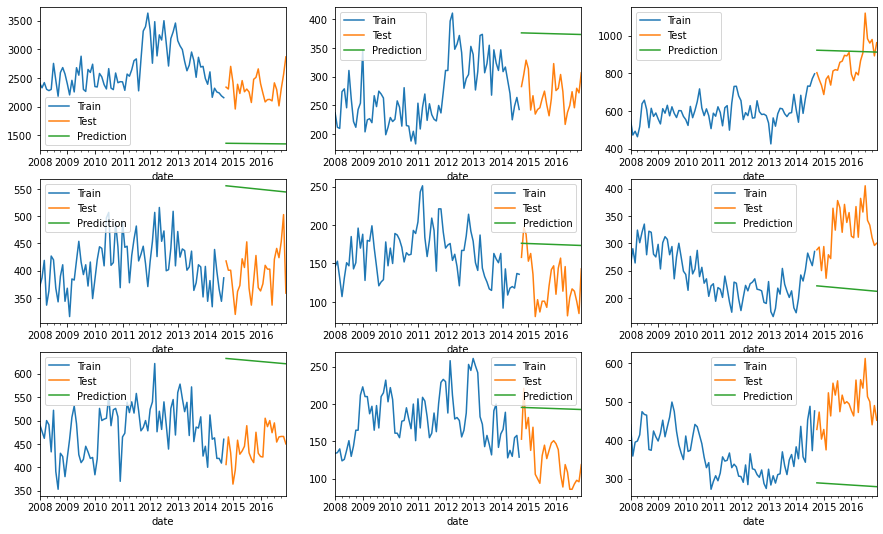

In [80]:
cat = ['Theft and Handling','Burglary','Violence Against the Person']
borough = ['Westminster','Merton','Barking and Dagenham']
plot_regression(borough, cat)

As we can see, the model currently returns quite a high mean squared error, and when plotting the prediction for a particular borough/category, the prediciton is quite far out.  After looking into this a bit, it seems we may have an issue of multi-collinearity, probably between crime category and borough.  Let's see if we can address this.

#### 2nd Iteration

In [81]:
# instead of creating separate categorical values for borough and category, let's create a blended dummy for every combination in the dataset
borough_cat_dummies = pd.get_dummies(crime_model['borough']+crime_model['minor_category'], prefix='d').drop(columns='d_WestminsterBurglary in Other Buildings')
crime_model = pd.concat([crime_model, borough_cat_dummies], axis=1)
crime_model.head(3)

,date,borough,major_category,minor_category,value,year,weekly_earnings,population,quarter,jsa,...,d_WestminsterOther Theft Person,d_WestminsterOther violence,d_WestminsterPersonal Property,d_WestminsterPossession Of Drugs,d_WestminsterRape,d_WestminsterTheft From Motor Vehicle,d_WestminsterTheft From Shops,d_WestminsterTheft/Taking Of Motor Vehicle,d_WestminsterTheft/Taking of Pedal Cycle,d_WestminsterWounding/GBH
0,2008-01-01,Barking and Dagenham,Burglary,Burglary in Other Buildings,55,2008,449.9,172500,2008Q1,2.110145,...,0,0,0,0,0,0,0,0,0,0
1,2008-01-01,Merton,Sexual Offences,Rape,4,2008,526.0,195900,2008Q1,1.061766,...,0,0,0,0,0,0,0,0,0,0
2,2008-01-01,Merton,Sexual Offences,Other Sexual,7,2008,526.0,195900,2008Q1,1.061766,...,0,0,0,0,0,0,0,0,0,0


In [82]:
#let's update the list of feature columns
feature_cols = crime_model.columns[ 
    (crime_model.columns.str.startswith('d_')) | \
    (crime_model.columns=='date_numeric')].to_list()

In [83]:
#run linear regression again
run_lr(feature_cols)

('RMSE: 32.68857809829361', 'Null RMSE: 78.73705808518876')

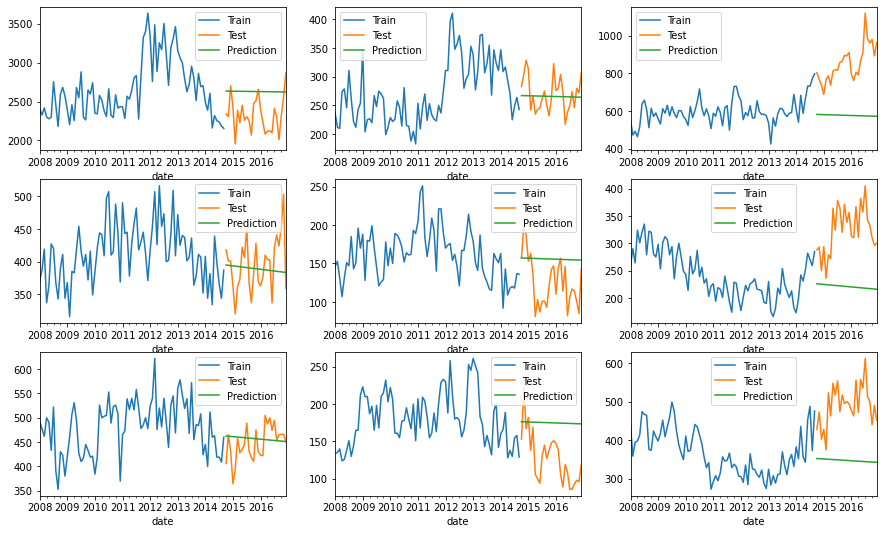

In [84]:
#plot the regression lines again... have they improved?
cat = ['Theft and Handling','Burglary','Violence Against the Person']
borough = ['Westminster','Merton','Barking and Dagenham']
plot_regression(borough, cat)

This is a decent improvement.  RMSE is down from 47 -> 32 and looking at the plots, we can see that the regression line is a better fit for every combination of Borough/ Category that we have plotted.

#### 3rd Iteration

In [85]:
# now let's see if adding one or more of the other features gives us an improvement
# let's create a loop to generate each possible combination of feature columns, and call the lr model to see which gives us the best RMSE.

In [86]:
#here is a list of the new features we added
new_features

['weekly_earnings',
 'population',
 'jsa',
 'NVQ4+',
 'NVQ3 only',
 'Trade Apprenticeships',
 'NVQ2 only',
 'NVQ1 only',
 'other qualifications',
 'no qualifications']

In [87]:
#create a new list of tuples containing every possible combination of these new features
import itertools
new_features_combo = []
for i in range(len(new_features)+1):
    new_features_combo.extend(list(itertools.combinations(new_features, i)))
len(new_features_combo)

1024

In [88]:
#let's start with the same feature cols as the previous run
feature_cols = crime_model.columns[ 
    (crime_model.columns.str.startswith('d_')) | \
    (crime_model.columns=='date_numeric')].to_list()

In [89]:
#Function which loops through all of the possible new feature combinations, 
#appends each one to the existing features, then runs the linear regression model
#and writes the RMSE to a dictionary along with the relevant feature combination that produced it

def test_features():
    
    #this thing takes an age to run, so I'm going to pickle the output so it can be retrieved without rerunning
    import pickle
    import hashlib
    
    #create the pickle filename by hashing the feature_cols variable so that we can store multiple pickles for each set feature cols
    features_pickle = 'data/features_' + hashlib.md5(str(feature_cols).encode()).hexdigest() + '.pickle'

    #check if the pickle file is there, if so then load it.
    if os.path.isfile(features_pickle):
        
        with open(features_pickle, 'rb') as f:
            d = pickle.load(f)

    else:
    
        import sys

        d = {}
        
        counter = len(new_features_combo)

        for item in new_features_combo:
            f = feature_cols.copy()
            f.extend(item)
            rmse = run_lr(f)

            d[item] = rmse

            counter = counter - 1
            sys.stdout.flush()
            sys.stdout.write(str(counter) + ' tests left to run!\r')
        
        with open(features_pickle, 'wb') as f:
            pickle.dump(d, f)
    
    return d     

In [90]:
tf = test_features()

In [91]:
#write the dictionary we just created into a dataframe, sort the values to get the lowest RMSE.
tf = pd.DataFrame.from_dict(tf, orient='index').reset_index().rename(columns={'index':'features',0:'RMSE'}).sort_values('RMSE').reset_index()
tf.head()

,index,features,RMSE
0,289,"(population, NVQ4+, Trade Apprenticeships, no ...",32.653081
1,104,"(population, NVQ4+, no qualifications)",32.655340
2,294,"(population, NVQ4+, NVQ1 only, no qualifications)",32.655372
3,561,"(population, NVQ4+, Trade Apprenticeships, NVQ...",32.655426
4,113,"(population, Trade Apprenticeships, no qualifi...",32.656244


In [92]:
#here are the features which give us the lowest RMSE
tf['features'][0]

('population', 'NVQ4+', 'Trade Apprenticeships', 'no qualifications')

As we can see, this is a very minor improvement.
I suspect this maybe because of overfitting, whereby the combinaton of "borough/ minor-category" is given a higher weight by the LinearRegression algorithm.
Purely for the sake of interest, let's try rerunning this test using ONLY the new features + date.

In [93]:
#let's start with the feature columns, minus the dummies representing borough/ minor category.
feature_cols = crime_model.columns[ 
    (crime_model.columns=='date_numeric')].to_list()

In [94]:
tf = test_features()

In [95]:
#write the dictionary we just created into a dataframe, sort the values to get the lowest RMSE.
tf = pd.DataFrame.from_dict(tf, orient='index').reset_index().rename(columns={'index':'features',0:'RMSE'}).sort_values('RMSE').reset_index()
tf.head().append(tf.tail())

,index,features,RMSE
0,899,"(weekly_earnings, population, NVQ3 only, Trade...",76.956196
1,695,"(weekly_earnings, population, NVQ3 only, Trade...",76.957066
2,428,"(weekly_earnings, population, NVQ3 only, NVQ2 ...",76.957183
3,679,"(weekly_earnings, population, NVQ4+, NVQ3 only...",76.958392
4,885,"(weekly_earnings, population, NVQ4+, NVQ3 only...",76.958579
1019,128,"(jsa, NVQ3 only, NVQ1 only)",80.182528
1020,586,"(jsa, NVQ4+, NVQ3 only, NVQ2 only, NVQ1 only)",80.238598
1021,317,"(jsa, NVQ4+, NVQ3 only, NVQ2 only)",80.294148
1022,120,"(jsa, NVQ4+, NVQ3 only)",80.520947
1023,318,"(jsa, NVQ4+, NVQ3 only, NVQ1 only)",80.535331


In [96]:
#here are the features which give us the lowest RMSE
tf['features'][0]

('weekly_earnings',
 'population',
 'NVQ3 only',
 'Trade Apprenticeships',
 'NVQ2 only',
 'NVQ1 only',
 'no qualifications')

In [97]:
#and for good measure, let's see how much of an improvement this is on JUST the time series

In [98]:
run_lr(feature_cols)

('RMSE: 78.82756764105343', 'Null RMSE: 78.73705808518876')

In summary then, we can see that Borough and Minor Category are very strong predictors for crime rates.
The additional features I added, didn't really result in any improvement in RMSE
- they were ignored by the LinearRegression when borough/minor category were included
- when using the date as the only other predictor, they only marginally improved the result.
In summary therefore, I conclude that without investigating more features, I've reached the limit of what basic Linear Regression could achieve.

As suggested at the beginning of the Modelling section, I would like to try an ARIMA model on the time series, and feed the output into the linear regression model I have built to see if that can achieve any improvement.
I'm going to use the Facebook Prophet model which should pick up any trend and seasonality in the time series data.

#### 4th Iteration

In [99]:
# Let's feed the timeseries data into the Facebook Prophet model
from fbprophet import Prophet

In [100]:
# Prophet takes a very specific data format, so I'll need to write a new dataframe containing the required information
# As a first pass,I'm going to run the time-series analysis on the entire London dataset at once
crime_prophet = crime_model[['date','value']].groupby(by='date').sum().reset_index().rename(columns={'date':'ds','value':'y'})

In [101]:
# check how many rows there are in the time series
len(crime_prophet)

108

In [102]:
#let's do a test/train split
train_y_prophet = crime_prophet[0:81]
test_y_prophet = crime_prophet[81:]

In [103]:
#now fit the prophet model with the test data
m = Prophet(daily_seasonality=False, weekly_seasonality=False)
m.fit(train_y_prophet)

In [104]:
#create the future data frame
#nb.  I had to make a small tweak to the facebook code so that that monthly interval would fall on the 1st of the month instead of the end
future = m.make_future_dataframe(periods=27, freq='M')

In [105]:
forecast = m.predict(future)
forecast[['ds','yhat']].tail()

,ds,yhat
103,2016-08-01,51214.373852
104,2016-09-01,48355.994572
105,2016-10-01,53011.983486
106,2016-11-01,51986.164295
107,2016-12-01,47851.748732


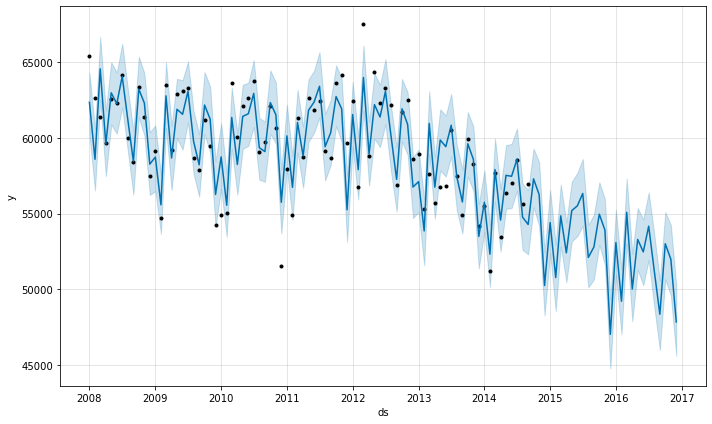

In [106]:
#we can plot the data using the integrated function
fig1 = m.plot(forecast)

In [107]:
# now let's join the data back to the main dataframe so we can feed into into the LR model
prophet_forecast = forecast[['ds','yhat']].rename(columns={'ds':'date','yhat':'prophet_pred'})
crime_model = crime_model.merge(right=prophet_forecast, how='left', on='date')

In [108]:
crime_model[['date','borough','major_category','minor_category','value','prophet_pred']]

,date,borough,major_category,minor_category,value,prophet_pred
0,2008-01-01,Barking and Dagenham,Burglary,Burglary in Other Buildings,55,62344.872258
1,2008-01-01,Merton,Sexual Offences,Rape,4,62344.872258
2,2008-01-01,Merton,Sexual Offences,Other Sexual,7,62344.872258
3,2008-01-01,Merton,Robbery,Personal Property,22,62344.872258
4,2008-01-01,Merton,Robbery,Business Property,11,62344.872258
...,...,...,...,...,...,...
112963,2016-12-01,Islington,Violence Against the Person,Murder,1,47851.748732
112964,2016-12-01,Islington,Violence Against the Person,Offensive Weapon,15,47851.748732
112965,2016-12-01,Islington,Violence Against the Person,Other violence,29,47851.748732
112966,2016-12-01,Islington,Theft and Handling,Theft/Taking Of Motor Vehicle,50,47851.748732


Interestingly, we can see that Prophet has produced a "prediction" for existing points that it actually had data for.  Before we feed this into the LinearRegression model, it might be worth trying 2 versions:
- First one with "actual" values in the training set
- Second one, using predicted values for both training and test set.

In [109]:
#write a new column (prophet_pred_revised) containing this change so we can test if it improves things.
crime_model.loc[crime_model['date'].isin(train_y_prophet['ds']), 'prophet_pred_revised'] = crime_model['value']
crime_model.loc[crime_model['date'].isin(test_y_prophet['ds']), 'prophet_pred_revised'] = crime_model['prophet_pred']

In [110]:
#Now let's run the linear regression model again, with both versions of the Prophet prediction
feature_cols = crime_model.columns[ 
    (crime_model.columns.str.startswith('d_')) | \
    (crime_model.columns.isin(['date_numeric','prophet_pred']))].to_list()

In [111]:
#run linear regression again
run_lr(feature_cols)

('RMSE: 33.34997847158284', 'Null RMSE: 78.73705808518876')

In [112]:
#Now let's try it with the "revised" Prophet numbers.
feature_cols = crime_model.columns[ 
    (crime_model.columns.str.startswith('d_')) | \
    (crime_model.columns.isin(['date_numeric','prophet_pred_revised']))].to_list()

In [113]:
run_lr(feature_cols)

('RMSE: 52744.523527312456', 'Null RMSE: 78.73705808518876')

So we can see that adding the Prophet data hasn't actually improved the model, at least when running it across the global London data.  When using the "revised" prediction, this has blown RMSE out completely.

This is almost definitely because of the difference in scale between the total London crime count (which is the number produced by the model) and the original input data, at borough/ minor category level.

I suspect another issue with the "revised" approach is overfitting so this may not be the best idea after all.

But... this was kind of what I was expecting since, in order for the model to be accurate, we would need to run an individual regression against the timeseries for every single combination of borough and crime category!

Let's try this here.

In [114]:
#let's drop the 2 prediction columns for now, so we don't have an issue when we rerun the model on the next iteration.
crime_model.drop(['prophet_pred','prophet_pred_revised'], axis=1, inplace=True)

#### 5th and final iteration!

In [115]:
# Build a function that loops through every combination of borough and minor category and runs the Prophet model against it.
crime_model.head(3)

,date,borough,major_category,minor_category,value,year,weekly_earnings,population,quarter,jsa,...,d_WestminsterOther Theft Person,d_WestminsterOther violence,d_WestminsterPersonal Property,d_WestminsterPossession Of Drugs,d_WestminsterRape,d_WestminsterTheft From Motor Vehicle,d_WestminsterTheft From Shops,d_WestminsterTheft/Taking Of Motor Vehicle,d_WestminsterTheft/Taking of Pedal Cycle,d_WestminsterWounding/GBH
0,2008-01-01,Barking and Dagenham,Burglary,Burglary in Other Buildings,55,2008,449.9,172500,2008Q1,2.110145,...,0,0,0,0,0,0,0,0,0,0
1,2008-01-01,Merton,Sexual Offences,Rape,4,2008,526.0,195900,2008Q1,1.061766,...,0,0,0,0,0,0,0,0,0,0
2,2008-01-01,Merton,Sexual Offences,Other Sexual,7,2008,526.0,195900,2008Q1,1.061766,...,0,0,0,0,0,0,0,0,0,0


In [116]:
from fbprophet import Prophet
import numpy as np
from datetime import datetime

In [117]:
#the idea here is basically to loop through all combinations of borough and category and run the Prophet model for each combination.

def agatha():
    
    #print the start time
    print('Start: ' + str(datetime.now()))
    
    #this thing takes an age to run, so I'm going to pickle the output so it can be retrieved without rerunning
    prophet_pickle = 'data/agatha.pickle'

    #check if the pickle file is there, if so then load it.
    if os.path.isfile(prophet_pickle):
        
        df = pd.read_pickle(prophet_pickle)

    else:
    
    
        #create some empty lists to house the output
        date = []
        borough = []
        category = []
        pred = []

        #we want to have a counter so we can track our progress.
        import sys
        model_count = len(arr_borough)*len(arr_cat)
        
        #create 2 arrays containing the unique posssible values for borough and category
        arr_borough = crime['borough'].unique()
        arr_cat = crime['minor_category'].unique()

        #The nested loops allows us to run every model
        #this will be the cartesian product of borough x category
        for b in arr_borough:

            for c in arr_cat:

                #create the required data set using the current borough and category
                data = crime[(crime['borough']==b) & (crime['minor_category']==c)][['date','value']].groupby(by='date').sum().reset_index().rename(columns={'date':'ds','value':'y'})

                #there are a couple of combinations of borough/ category that are missing so we need to control for that.
                if data.empty == False:
                    #every data set is 108 rows, so we split it at the 75% point (test using rows 0-81, train using 82-108)
                    train_y = data[:81]
                    test_y = data[81:]

                    #run the model, and predict for 27 monthly future periods
                    m = Prophet(weekly_seasonality=False, daily_seasonality=False)
                    m.fit(train_y)
                    future = m.make_future_dataframe(periods=27, freq='M')
                    forecast = m.predict(future)

                    #populate the borough and category in the dataframe as we'll need this later
                    forecast['borough'] = b
                    forecast['category'] = c

                    #add the output to the bottom of the lists
                    date.extend(forecast['ds'].to_list())
                    borough.extend(forecast['borough'].to_list())
                    category.extend(forecast['category'].to_list())
                    pred.extend(forecast['yhat'].to_list())

                else:
                    print(f'Combination of ({b}, {c}) is not present in the dataset.')

                #update the counter
                model_count = model_count - 1
                sys.stdout.flush()
                sys.stdout.write(str(model_count) + ' predictions to go!\r')

        #create a new dataframe from the lists and return it        
        df = pd.DataFrame(list(zip(date, borough, category, pred)), 
                   columns =['date', 'borough', 'category', 'prophet_pred'])
        
        df.to_pickle(prophet_pickle)
    
    #print the end time
    print('End: ' + str(datetime.now()))
    
    return df


In [118]:
prophet_output = agatha()
prophet_output.head()

Start: 2020-09-16 12:40:18.248435
End: 2020-09-16 12:40:18.275435


,date,borough,category,prophet_pred
0,2008-01-01,Barking and Dagenham,Burglary in Other Buildings,55.180808
1,2008-02-01,Barking and Dagenham,Burglary in Other Buildings,58.268186
2,2008-03-01,Barking and Dagenham,Burglary in Other Buildings,53.524926
3,2008-04-01,Barking and Dagenham,Burglary in Other Buildings,54.511690
4,2008-05-01,Barking and Dagenham,Burglary in Other Buildings,56.750087


In [119]:
#let's join the new predicitions to our main dataset so we can rerun the linear regression.
prophet_output.rename(columns={'category':'minor_category'}, inplace=True)
crime_model = crime_model.merge(right=prophet_output, how='left', on=['date','borough','minor_category'])
crime_model.head(3)

,date,borough,major_category,minor_category,value,year,weekly_earnings,population,quarter,jsa,...,d_WestminsterOther violence,d_WestminsterPersonal Property,d_WestminsterPossession Of Drugs,d_WestminsterRape,d_WestminsterTheft From Motor Vehicle,d_WestminsterTheft From Shops,d_WestminsterTheft/Taking Of Motor Vehicle,d_WestminsterTheft/Taking of Pedal Cycle,d_WestminsterWounding/GBH,prophet_pred
0,2008-01-01,Barking and Dagenham,Burglary,Burglary in Other Buildings,55,2008,449.9,172500,2008Q1,2.110145,...,0,0,0,0,0,0,0,0,0,55.180808
1,2008-01-01,Merton,Sexual Offences,Rape,4,2008,526.0,195900,2008Q1,1.061766,...,0,0,0,0,0,0,0,0,0,1.324829
2,2008-01-01,Merton,Sexual Offences,Other Sexual,7,2008,526.0,195900,2008Q1,1.061766,...,0,0,0,0,0,0,0,0,0,2.284226


In [120]:
# with prophet pred
feature_cols = crime_model.columns[ 
    (crime_model.columns.str.startswith('d_')) | \
    (crime_model.columns.isin(['date_numeric','prophet_pred']))].to_list()
run_lr(feature_cols)

('RMSE: 29.15550316080547', 'Null RMSE: 78.73705808518876')

RMSE of 29?  Not bad considering we started from 47!
Let's have a look at the graphs too...

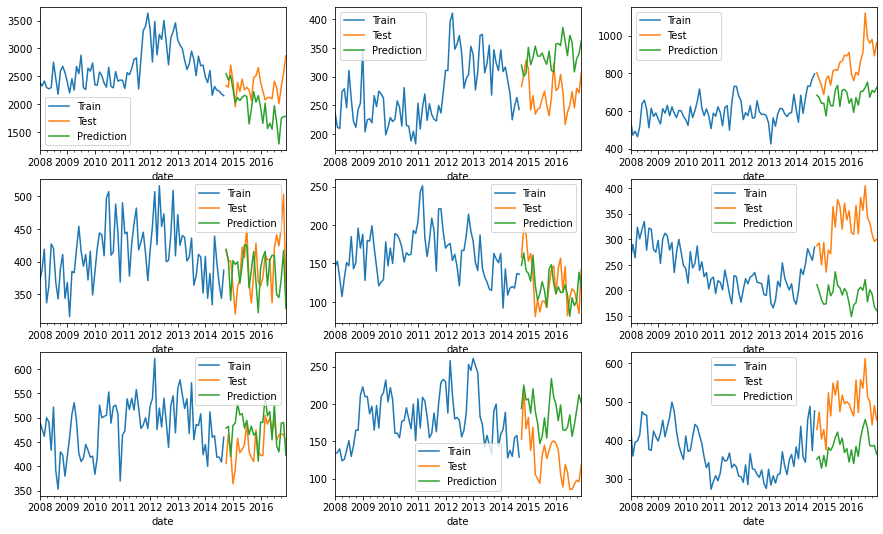

In [121]:
#plot the regression lines again... have they improved?
cat = ['Theft and Handling','Burglary','Violence Against the Person']
borough = ['Westminster','Merton','Barking and Dagenham']
plot_regression(borough, cat)

Not too shabby, and I think its about as far as I'm going to go with it!
Couple more observations though.
I noticed that if I now run my linear regression model with JUST the prophet output, I get the same RMSE and the same plots.  
The LinearRegression model appears to be overfitting the Prophet output, thus ignoring the other features.
In hindsight, this is probably unsurprising!

In [122]:
feature_cols = crime_model.columns[ 
    (crime_model.columns.isin(['date_numeric','prophet_pred']))].to_list()
run_lr(feature_cols)

('RMSE: 28.23442705850153', 'Null RMSE: 78.73705808518876')

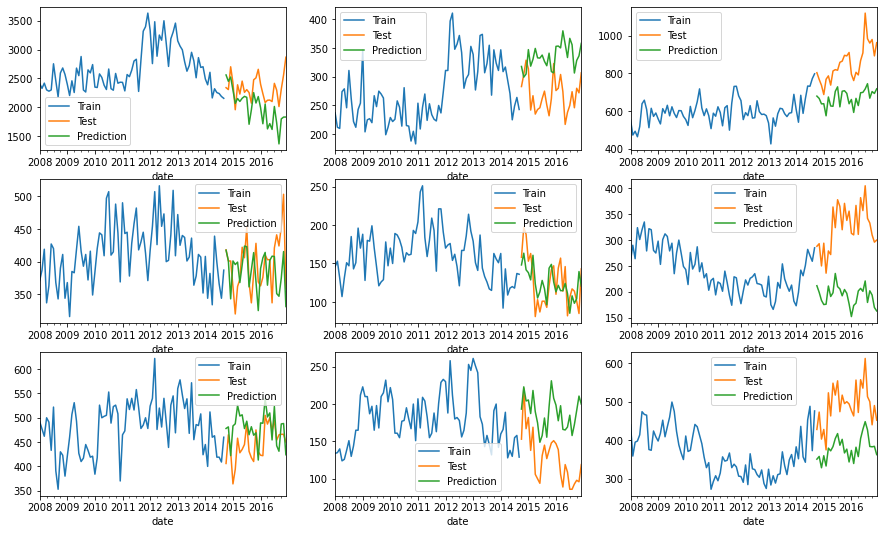

In [123]:
#plot the regression lines again... have they improved?
cat = ['Theft and Handling','Burglary','Violence Against the Person']
borough = ['Westminster','Merton','Barking and Dagenham']
plot_regression(borough, cat)